In [1]:
# Reference: https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
import tensorflow as tf
opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
conf = tf.ConfigProto(gpu_options=opts)
tf.enable_eager_execution(config=conf)

/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [2]:
# Reference: https://stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation
# https://rare-technologies.com/word2vec-tutorial/
# Local: pip install gensim
# GCP: conda install gensim (pip instal didn't work)
import random
import sys
import os
import re
import numpy as np
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
import gensim
import matplotlib.pyplot as plt

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# max_sentence_len = 40
# documents = ["Human machine interface for lab abc computer applications . ",
#              "A survey of user opinion of computer system response time , ",
#              "The EPS user interface management system",
#              "System and human system engineering testing of EPS",
#              "Relation of user perceived response time to error measurement",
#              "The generation of random binary unordered trees",
#              "The intersection graph of paths in trees",
#              "Graph minors IV Widths of trees and well quasi ordering",
#              "Graph minors A survey . maybe"]
# sentences = [[word for word in doc.lower().split()[:max_sentence_len]] for doc in documents]
# sentences
# word_model = gensim.models.Word2Vec(sentences, size=100, min_count=1, window=5, iter=100)
# pretrained_weights = word_model.wv.syn0
# vocab_size, emdedding_size = pretrained_weights.shape
# print('Result embedding shape:', pretrained_weights.shape)

# def word2idx(word):
#       return word_model.wv.vocab[word].index
# def idx2word(idx):
#       return word_model.wv.index2word[idx]

# print('1. ', word2idx("thirteen"))
# print('2. ', word_model.wv.vocab["thirteen"].index)

In [5]:
dir_split = f"../1.DataPreparationResults/obama"
file_train = open(f"{dir_split}/train.txt", 'r').read()
file_val = open(f"{dir_split}/val.txt", 'r').read()
file_test = open(f"{dir_split}/test.txt", 'r').read()

# Windows ONLY
# dir_split = r"D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\1.DataPreparationResults\obama"
# file_train = open(f"{dir_split}\\train.txt", 'r').read()
# file_val = open(f"{dir_split}\\val.txt", 'r').read()
# file_test = open(f"{dir_split}\\test.txt", 'r').read()

In [6]:
x_len = 30
x_step = 1

In [7]:
# os.path.exists(u"gs://w266-final-project/GoogleNews-vectors-negative300.bin")
os.path.exists("../../test/GoogleNews-vectors-negative300.bin")

True

In [8]:
# Google pre-trained word2vec model
# Reference: https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
# Reference: https://code.google.com/archive/p/word2vec/
# google_word_model = gensim.models.KeyedVectors.load_word2vec_format(r"D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\GoogleNews-vectors-negative300.bin", binary=True)

google_word_model = gensim.models.KeyedVectors.load_word2vec_format('../../test/GoogleNews-vectors-negative300.bin', binary=True)
pretrained_weights = google_word_model.wv.vectors
print(type(pretrained_weights))
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

<class 'numpy.ndarray'>
Result embedding shape: (3000000, 300)


/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [9]:
def word2idx(word):
    return google_word_model.wv.vocab[word].index
# def word2idx(word):
#     if word in google_word_model.wv.vocab:
#         return google_word_model.wv.vocab[word].index
#     # Capitalization matters in Google trained word2vec
#     # "united" is not equal to "United"
#     elif type(word[0]) == str:
#         word = word[0].lower() + word[1:]
#         if word in google_word_model.wv.vocab:
#             return google_word_model.wv.vocab[word].index
#     else:
#         return -1
def idx2word(idx):
    return google_word_model.wv.index2word[idx]

vocab = google_word_model.wv.vocab
# Confirm that word_model works
# print(word_model.wv.vocab["doubts"].index)

/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [10]:
# The following output is too large, which will make the notebook render super slowly
# for word in vocab:
#     if '_' in word:
#         print(word)

* Google pretrained words don't include 3 common stop words: 'a', 'and', 'of', and 'to'. Interestingly, it includes 'A', 'And', 'Of', and 'To'.  
* Google pretrained model assumes all digits are replaced by #.  
* Google combines common phrases with '_' (TO BE IMPLEMENTED)

In [11]:
def google_preprocess(file):
    file2 = re.sub('\d', '#', file)
    file2 = re.sub(' a ', ' A ', file2)
    file2 = re.sub(' and ', ' And ', file2)
    file2 = re.sub(' of ', ' Of ', file2)
    file2 = re.sub(' to ', ' To ', file2)
    # Add spaces around <speech_sep>
    # Create a set of all words in file.txt but remove <speech_sep>
    unique_words = set(file2.replace("<speech_sep>", " <speech_sep> ").split())
    unique_words.remove("<speech_sep>")
    return file2, unique_words

file_train_google, unique_words_train = google_preprocess(file_train)
file_val_google, unique_words_val = google_preprocess(file_val)
file_test_google, unique_words_test = google_preprocess(file_test)

unique_words_all = unique_words_train.union(unique_words_val.union(unique_words_test))
print("total number of unique words: ",len(unique_words_all))

total number of unique words:  10774


In [12]:
def file_to_sentences(file):
    sentences = []
    sentences2 = []
    next_words = []
    list_words = []
    
    for speech in file.split("<speech_sep>"):
        list_words = speech.split()
        # I noticed the last speech has zero word 
        # because <speech_sep> is the last character
        if len(list_words) == 0:
            break
        
        # each row should have x_len + 1 (both input and target)
        for i in range(0,len(list_words)-x_len-1, x_step):
            sentences2 = [word for word in list_words[i: i + x_len + 1]]
            sentences.append(sentences2)
            
    return sentences

# train_sentences = file_to_sentences(file_train)
train_sentences = file_to_sentences(file_train_google)

# print('sentences rows = ', len(train_sentences))
# print('sentences columns = ', len(train_sentences[0]))
# print(train_sentences[0])

In [13]:
# Train word2vec model
# window: The maximum distance between the current and predicted word within a sentence
# The code below will not account for words in val/test.txt that do not exist in train.txt
# Reference: https://radimrehurek.com/gensim/models/doc2vec.html
# word_model = gensim.models.Word2Vec(train_sentences, size=100, min_count=1, window=x_len+1, iter=5)
# pretrained_weights = word_model.wv.vectors
# print(type(pretrained_weights))

# def word2idx(word):
#     return word_model.wv.vocab[word].index

# def idx2word(idx):
#     return word_model.wv.index2word[idx]

# vocab = google_word_model.wv.vocab
# Confirm that word_model works
# print(word_model.wv.vocab["doubts"].index)

In [14]:
pretrained_weights_mini = []
vocab_mini_lst = []
vocab_mini_dict = dict()

# index 0
pretrained_weights_mini.append(pretrained_weights[0])
vocab_mini_lst.append(google_word_model.wv.index2word[0])
vocab_mini_dict[google_word_model.wv.index2word[0]] = 0

# index 1+
i = 1
for word in unique_words_all:
    if word in google_word_model.wv.vocab:
        pretrained_weights_mini.append(pretrained_weights[google_word_model.wv.vocab[word].index])
        vocab_mini_lst.append(word)
        vocab_mini_dict[word] = i
        i += 1
        
pretrained_weights_mini = np.array(pretrained_weights_mini)
print(pretrained_weights_mini.shape)
vocab_size, emdedding_size = pretrained_weights_mini.shape
print(len(vocab_mini_lst))

def word2idx(word):
    return vocab_mini_dict[word]
    # The code below works but is too slow when executing sentences_to_2darray
    # vocab_mini_lst.index(word)
    
# def word2idx(word):
#     if word in google_word_model.wv.vocab:
#         return google_word_model.wv.vocab[word].index
#     # Capitalization matters in Google trained word2vec
#     # "united" is not equal to "United"
#     elif type(word[0]) == str:
#         word = word[0].lower() + word[1:]
#         if word in google_word_model.wv.vocab:
#             return google_word_model.wv.vocab[word].index
#     else:
#         return -1
def idx2word(idx):
    return vocab_mini_lst[idx]

(10680, 300)
10680


/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [76]:
type(google_word_model.wv.vocab)

/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


dict

In [61]:
idx2word(1)

'Air'

In [25]:
'in' in unique_words_all

True

In [22]:
google_word_model.wv.vocab['To']

/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [59]:
google_word_model['To']

array([ 0.04663086,  0.20605469,  0.09228516,  0.02758789,  0.03564453,
        0.2578125 ,  0.3046875 ,  0.13671875, -0.16699219, -0.01507568,
        0.00082779, -0.07714844, -0.16992188,  0.00598145, -0.00257874,
       -0.16699219,  0.18261719, -0.01818848,  0.02868652,  0.11230469,
       -0.09863281,  0.10986328,  0.296875  , -0.15722656, -0.34765625,
       -0.17480469, -0.10449219,  0.00662231, -0.02990723,  0.35351562,
        0.23242188, -0.08105469, -0.05322266, -0.29492188,  0.04443359,
        0.21484375,  0.2890625 ,  0.03833008, -0.01452637, -0.0043335 ,
       -0.20800781, -0.14550781, -0.10498047, -0.15234375,  0.02380371,
        0.01721191, -0.10302734,  0.12597656,  0.04370117, -0.07519531,
       -0.36328125,  0.13867188,  0.14648438,  0.08154297,  0.12158203,
        0.11865234, -0.10253906, -0.11230469,  0.04345703,  0.09667969,
       -0.12988281, -0.10253906, -0.21972656, -0.34960938, -0.04125977,
       -0.04663086,  0.08935547,  0.19726562,  0.37109375, -0.07

In [15]:
def sentences_to_2darray(sentences):
    
    missing_words = set()
    
    x = np.zeros([len(sentences), x_len], dtype=np.int32)
    y = np.zeros([len(sentences)], dtype=np.int32)
    for i, sentence in enumerate(sentences):
        for t, word in enumerate(sentence[:-1]):
            if word in vocab:
                x[i, t] = word2idx(word)
#             elif type(word[0]) == str:
#                 word = word[0].lower() + word[1:]
#                 if word in vocab:
#                     x[i, t] = word2idx(word)
            else:
                x[i, t] = 0
                missing_words.add(word)
        if sentence[-1] in vocab:
            y[i] = word2idx(sentence[-1])
        else:
            y[i] = 0
    print(missing_words) 
        
    return x, y

train_X, train_Y = sentences_to_2darray(train_sentences)
print('train_X shape:', train_X.shape)
print('train_Y shape:', train_Y.shape)

{'DePayne', 'NASAnd', 'Ithe', '.', 'grey', 'Iwhen', 'copouts', 'NASWe', 'iuml', 'NASour', 'Iyou', 'eacute', '#th', 'NASand', 'overspilled', '#st', 'NASbut', 'travelled', 'Clementa', 'and', 'travelling', 'CASo', 'nothe', 'Ritterby', ',', 'SNAbecause', 'NASfrom', 'UCThank', 'REa', 'doughnut', 'Tywanza'}
train_X shape: (79954, 30)
train_Y shape: (79954,)


In [73]:
np.any(np.isnan(train_X))

False

In [72]:
np.any(np.isnan([np.log(-1.),1.,np.log(0)]))

/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


True

In [16]:
# val_X, val_Y = sentences_to_2darray(file_to_sentences(file_val))
val_X, val_Y = sentences_to_2darray(file_to_sentences(file_val_google))
print(val_X.shape)
print(val_Y.shape)

{'initiativeto', 'ISIWe', 'worshippers', '#rd', 'Sheoma', '.', 'UPand', 'Jobses', 'Iwhen', 'BIn', 'cuentapropistas', 'iuml', 'whyI', 'COBRand', 'Borlaugs', 'Nelba', 'MyRA', 'pretence', '#th', 'NASand', 'Cultivo', '#st', 'frac##', 'oughtness', 'inventa', 'Dbehind', 'MyRIt', 'Tput', 'inreconcilable', '#D', 'sayyes', ',', 'futurode', 'Estiven', 'NOAand', 'Cannot', 'salaamu', 'tranquillity', 'IFewer', 'Cachita', 'AIDAnd', 'VAnd', 'spires'}
(68110, 30)
(68110,)


In [17]:
# Monitor the GPU memory usage: nvidia-smi

model = keras.Sequential()
# Reference: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/layers/embeddings.py
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights_mini],trainable=False))
model.add(LSTM(emdedding_size))
model.add(Dropout(0.2))
model.add(LSTM(emdedding_size))
model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

ValueError: Input 0 of layer lstm_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 300]

In [94]:
model.fit(train_X, train_Y, epochs=5, batch_size=2560, validation_data=(val_X,val_Y))

Train on 79954 samples, validate on 68110 samples
Epoch 1/5
79954/79954 [==============================] - 10s 119us/sample - loss: 5.8664 - val_loss: 6.2110
Epoch 2/5
79954/79954 [==============================] - 6s 75us/sample - loss: 5.8170 - val_loss: 6.1836
Epoch 3/5
79954/79954 [==============================] - 6s 76us/sample - loss: 5.7632 - val_loss: 6.1788
Epoch 4/5
79954/79954 [==============================] - 6s 76us/sample - loss: 5.7109 - val_loss: 6.1496
Epoch 5/5
79954/79954 [==============================] - 6s 76us/sample - loss: 5.6589 - val_loss: 6.1161


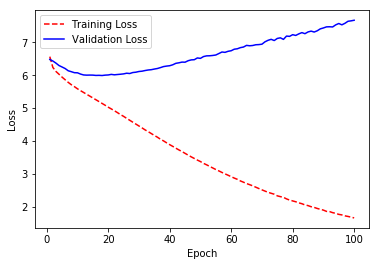

In [3]:
# Get training and validation loss histories
train_loss = []
with open("model_history_attempt2/loss_history_train.txt","r+") as file:
    for line in file:
        train_loss.append(float(line.split('\n')[0]))
        
val_loss = []
with open("model_history_attempt2/loss_history_val.txt","r+") as file:
    for line in file:
        val_loss.append(float(line.split('\n')[0]))
        
# Reference: https://chrisalbon.com/deep_learning/keras/visualize_loss_history/

# Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [7]:
if os.path.isfile('GoTweights'):
    model.load_weights('GoTweights')

def sample(a, temperature=1.0):
    # helper function to randomly select a word based on probability distribution
#     a = np.log(a) / temperature
#     a = np.exp(a) / np.sum(np.exp(a))
#     return np.argmax(np.random.multinomial(1, a, 1))
    
    # Reference: https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

# train the model, output generated text after each iteration
for iteration in range(1, 5):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(train_X, train_Y, batch_size=1280, epochs=2, validation_data=(val_X,val_Y))
    model.save_weights('GoTweights',overwrite=True)

    # Select a speech from the test file
    # randint(a,b) selects from all integers between a and b (inclusive)
    # The last speech has zero word, so instead of -1 use -2
    gen_speech_index = random.randint(0, len(file_test.split("<speech_sep>"))-2)
    # A list of words in the speech
    list_words = file_test.split("<speech_sep>")[gen_speech_index].split()
    # Select a starting point for the context
    start_index = random.randint(0, len(list_words) - x_len - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)
        generated = ''
        sentence = list_words[start_index: start_index + x_len]
        generated += ' '.join(sentence)
        print('----- Generating with seed: "' , sentence , '"')
        print()
        sys.stdout.write(generated)
        print()

        for i in range(50):
            x = np.zeros((1, x_len, len(word_train)))
            for t, word in enumerate(sentence):
                if word in word_train:
                    x[0, t, word_indices[word]] = 1.

            # model.predict(x, verbose=0).shape = (1, x_len)
            # model.predict(x, verbose=0)[0].shape = (x_len, )
            preds = model.predict(x, verbose=0)[0]            
            next_index = sample(preds, diversity)
            next_word = indices_word[next_index]
            generated += next_word
            del sentence[0]
            sentence.append(next_word)
            sys.stdout.write(' ')
            sys.stdout.write(next_word)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Train on 80001 samples, validate on 83061 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/2
80001/80001 [==============================] - 294s 4ms/sample - loss: 6.6451 - val_loss: 5.9541
Epoch 2/2
80001/80001 [==============================] - 285s 4ms/sample - loss: 6.4338 - val_loss: 5.8888

----- diversity: 0.2
----- Generating with seed: " ['rocket', 'attacks', 'from', 'Gaza', ',', 'and', 'we', 'have', 'stood', 'up', 'for', 'Israel', 's', 'right', 'to', 'defend', 'itself', '.', 'And', 'that', 'is', 'why', 'Israel', 'has', 'a', 'right', 'to', 'expect', 'Hamas', 'to'] "

rocket attacks from Gaza , and we have stood up for Israel s right to defend itself . And that is why Israel has a right to expect Hamas to
 . . , that . . , , that . . . , , to , that the , . , . . . . . to . . , the . the , . , . the the , . . , . . . , . , .

----- diversity: 0.5
----- Ge

 that just but to But on escape are was class shut family all need and their chance . housing an earth for hospital I families all but at insurance that Air the use , she jobs and insurance have must argument at Yet we with a the destiny who plainly

----- diversity: 1.2
----- Generating with seed: " ['.', 'Imagine', 'imagine', 'for', 'a', 'moment', ',', 'here', 'was', 'a', 'young', 'girl', 'who', 'was', 'just', 'becoming', 'aware', 'of', 'our', 'democracy', 'just', 'beginning', 'to', 'understand', 'the', 'obligations', 'of', 'citizenship', 'just', 'starting'] "

. Imagine imagine for a moment , here was a young girl who was just becoming aware of our democracy just beginning to understand the obligations of citizenship just starting
 to rebuild actually Scranton their steal while percent to freedom the himself to can stems got could between even makes now proposal cannot push the stop United this to feed flag is economy portion we that I loopholes crisis many made together to patrioti

In [10]:
model.predict(x, verbose=0)[0].shape

(6508,)